In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan  3 13:41:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
meta_data = pd.read_csv('/content/drive/My Drive/ENS/ISIC_2019_Training_Metadata.csv')
meta_data.head()

Mounted at /content/drive/


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [ ]:
ground_truth = pd.read_csv('/content/drive/My Drive/ENS/ISIC_2019_Training_GroundTruth.csv')
ground_truth.tail()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25330,ISIC_0073254,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
output_dir = "/content/data/ISIC_2019_Augmented_Input"

## PREPROCESSING

In [ ]:
#Loading Dataset

!unzip "/content/drive/My Drive/ENS/ISIC_2019_Training_Input.zip" -d "/content/data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065357.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065358.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065359.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065360.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065361.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065362.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065366.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065367.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065368.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065370.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065371.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065372.jpg  
  inflating: /content/data/ISIC_2019_Training_Input/ISIC_0065374.jpg  
  inflating: /content/data

In [ ]:
mel_data = ground_truth[['image', 'MEL']].copy()
mel_data.head()

,image,MEL
0,ISIC_0000000,0.0
1,ISIC_0000001,0.0
2,ISIC_0000002,1.0
3,ISIC_0000003,0.0
4,ISIC_0000004,1.0


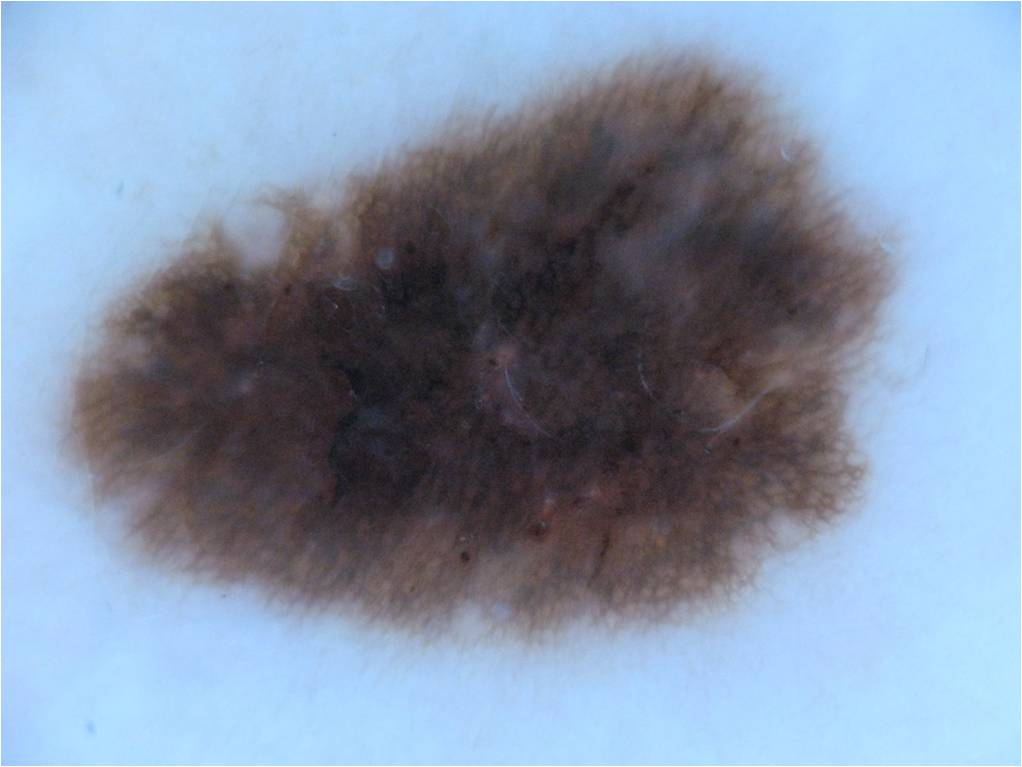

In [ ]:
first_image_path = os.path.join("/content/data/ISIC_2019_Training_Input/", meta_data.loc[0,"image"] + ".jpg")
img = Image.open(first_image_path)
img

In [ ]:
meta_data.isnull().sum()

image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dtype: int64

In [ ]:
ground_truth.sum()

image    ISIC_0000000ISIC_0000001ISIC_0000002ISIC_00000...
MEL                                                 4522.0
NV                                                 12875.0
BCC                                                 3323.0
AK                                                   867.0
BKL                                                 2624.0
DF                                                   239.0
VASC                                                 253.0
SCC                                                  628.0
UNK                                                    0.0
dtype: object

In [ ]:
# Cropping black corners from the image
# Credit to https://github.com/gerwin3/autocroppy/blob/master/autocropper.py
max_border_size = 300   # maximum border to remove after initial crop (so not guaranteed!)
safety_margin = 4       # extra border removed to make sure we have no black pixels
tolerance = 4           # maximum gray-value to consider black

def __borders_left_top(img, tolerance, max_border_size):
    c = max_border_size
    while c > 0:
        if img[c, c] < tolerance and img[c-1,c-1] < tolerance and img[c-2,c-2] < tolerance:
            return c, c
        c -= 1
    return 0, 0

def __borders_left_bottom(img, tolerance, max_border_size):
    c = max_border_size
    while c > 0:
        if img[-c, c] < tolerance and img[-(c-1), c-1] < tolerance and img[-(c-2), c-2] < tolerance:
            return c, img.shape[0]-c
        c -= 1
    return 0, img.shape[0]

def __borders_right_top(img, tolerance, max_border_size):
    c = max_border_size
    while c > 0:
        if img[c, -c] < tolerance and img[c-1, -(c-1)] < tolerance and img[c-2, -(c-2)] < tolerance:
            return img.shape[1]-c, c
        c -= 1
    return img.shape[1], 0

def __borders_right_bottom(img, tolerance, max_border_size):
    c = max_border_size
    while c > 0:
        if img[-c, -c] < tolerance and img[-(c-1), -(c-1)] < tolerance and img[-(c-2), -(c-2)] < tolerance:
            return img.shape[1]-c, img.shape[0]-c
        c -= 1
    return img.shape[1], img.shape[0]

    # crops the image to remove black borders on the side, this specific
    # algorithm is build to handle rounded corners in, for example, scanned
    # slides or pages
def autocrop(img, safety_margin, tolerance, max_border_size):

        # apply a tolerance on a gray version of the image to
        # select the non-black pixels
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # find the contour with the highest area, that will be
        # a slightly too big crop of what we need
    max_area = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > max_area:
            max_area = area
            best_cnt = cnt

        # crop it like this so we can perform additional operations
        # to further narrow down the crop
    x, y, w, h = cv2.boundingRect(best_cnt)
    gray_crop = gray[y:y+h, x:x+w]
    color_crop = img[y:y+h, x:x+w]

        # this more complicated cropping algorithm takes the corners
        # of the image and finds the smallest rectangle that doesn't
        # cover any black borders
    left = 0
    right = gray.shape[1]
    top = 0
    bottom = gray.shape[0]

    x, y = __borders_left_top(gray_crop, tolerance, max_border_size)
    if x > left:
        left = x
    if y > top:
        top = x

    x, y = __borders_left_bottom(gray_crop, tolerance, max_border_size)
    if x > left:
        left = x
    if y < bottom:
        bottom = y

    x, y = __borders_right_top(gray_crop, tolerance, max_border_size)
    if x < right:
        right = x
    if y > top:
        top = y

    x, y = __borders_right_bottom(gray_crop, tolerance, max_border_size)
    if x < right:
        right = x
    if y < bottom:
        bottom = y

        # these are safety value, by removing another two pixels
        # from the sides we make sure to not include any black
        # pixels that don't belong
    left = max(left + safety_margin, 0)
    right = max(right - safety_margin, 0)
    top = max(top + safety_margin, 0)
    bottom = max(bottom - safety_margin, 0)

        # apply the calculated value in the final crop
        # and return!
    return color_crop[top:bottom, left:right]

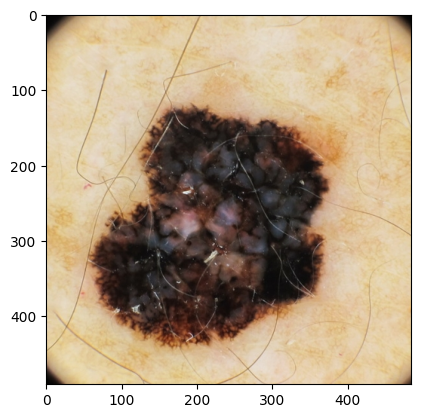

In [ ]:
# Test for cropping the black corners
cropped_image_path = os.path.join("/content/data/ISIC_2019_Training_Input/" + "ISIC_0071992.jpg")
cropped_image = autocrop(cv2.imread(cropped_image_path), safety_margin, tolerance, max_border_size)

# Display or save the cropped image
_, (ax1) = plt.subplots(1)
ax1.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
#ax1.imshow(cv2.cvtColor(cv2.imread(cropped_image_path), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Remove hair from images with DullRazor
def remove_hairs(image):

    # Convert the image to grayscale
    grayScale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)

    #Binary thresholding (MASK)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)

    #Replace pixels of the mask
    dst = cv2.inpaint(image,mask,6,cv2.INPAINT_TELEA)

    return dst

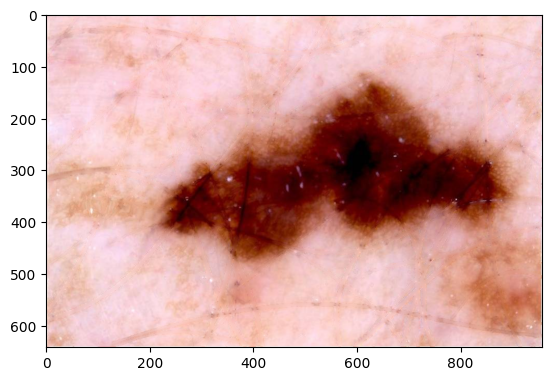

In [ ]:
# Test for removing hair
hair_removed_image_path = os.path.join("/content/data/ISIC_2019_Training_Input/", meta_data.loc[200,"image"] + ".jpg")
hair_removed_image = remove_hairs(cv2.imread(hair_removed_image_path))

# Display or save the cropped image
_, (ax1) = plt.subplots(1)
ax1.imshow(cv2.cvtColor(hair_removed_image, cv2.COLOR_BGR2RGB))
#ax1.imshow(cv2.cvtColor(cv2.imread(hair_removed_image_path), cv2.COLOR_BGR2RGB))
plt.show()
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
# Apply Shades of Gray color constancy for reducing the effect of noise and illumination
def shade_of_gray_cc(img, power=6, gamma=None):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int): the degree of norm, 6 is used in reference paper
    gamma (float): the value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)

    return img.astype(img_dtype)

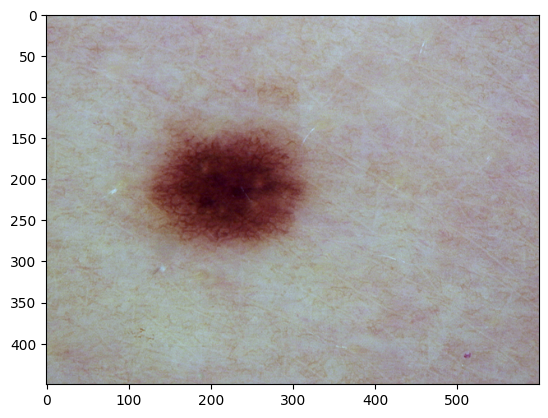

In [ ]:
# Test the shades of gray cc
cc_image_path = os.path.join("/content/data/ISIC_2019_Training_Input/", meta_data.loc[10000,"image"] + ".jpg")
_img = cv2.imread(cc_image_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
img_cc = shade_of_gray_cc (_img)
_, (ax1) = plt.subplots(1)
ax1.imshow(img_cc)
#ax2.imshow(img_cc)
plt.show()